<a href="https://colab.research.google.com/github/minu960125/2021_Dacon_exercise/blob/main/%EB%8D%B0%EC%9D%B4%EC%BD%98%EB%B6%84%EC%84%9D_%EC%BD%94%EB%93%9C%EB%A6%AC%EB%B7%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
주어진 데이터
18~20년 까지 2년간의 데이콘 데이터(방문자, 대회 개최정보 등...)

1차오픈
submission.csv : 20년 11월 9~ 21년 1월 8까지의 빈 데이터 양식 (이 양식에 채워넣어야함)
train.csv : 18년 9월 9일 ~ 20년 11월 8일까지의 데이터 사용자, 세션, 신규방문자, 페이지뷰가 들어있다 (이것을 잘 학습시켜서 미래를 예측해야함)

1차추가 데이터(18년 08월 ~20년 12월)
통찰 : 날짜별로의 대회 수가 중요할 듯
new_competition_info.csv : 대회개최정보를 담고있다
new_login_info.csv : 로그인 정보를 담고있다.
new_submission_info.csv : 제출양식
new_user_info.csv : 유저정보 담고있다.

2차오픈
2차_train.csv : 20년 11월 9일 ~ 20년 12월 8일까지의 데이터(추가 학습시켜서 더 미래를 예측)

2차추가 데이터(기존 1차에서 21년 1월정보 추가)
new_competition_info.csv : 대회개최정보를 담고있다
new_login_info.csv : 로그인 정보를 담고있다.
new_submission_info.csv : 제출양식
new_user_info.csv : 유저정보 담고있다.

목표
1차 : 20년 11월 9일 ~ 20년 12월 8일 까지의 데이터를 예측
2차 : 20년 12월 9일 ~ 21년 1월 8일 까지의 데이터를 예측

예측 데이터 속성
사용자 수, 세션수, 신규 방문자 수, 페이지 뷰 총 4가지 항목

규칙
심사기준 : Weighted RMSE 
평균 제곱근 편차(Root Mean Square Deviation)
추정 값 또는 모델이 예측한 값과 실제 환경에서 관찰되는 값의 차이를 다룰 때 흔히 사용하는 측도이다. 
정밀도(precision)를 표현하는데 적합하다. 각각의 차이값은 잔차(residual)라고도 하며, 
평균 제곱근 편차는 잔차들을 하나의 측도로 종합할 때 사용된다.
(a-b)^2
리뷰한 코드 : private 1위
사용한 방법 : Linear Regression
선형 회귀(linear regression)는 종속 변수 y와 한 개 이상의 독립 변수 (또는 설명 변수) X와의 선형 상관 관계를 모델링하는 회귀분석 기법이다.

스케일러의 중요성

데이터를 모델링하기 전에는 반드시 스케일링 과정을 거쳐야 한다. 스케일링을 통해 다차원의 값들을 비교 분석하기 쉽게 만들어주며, 자료의 오버플로우(overflow)나 언더플로우(underflow)를 방지 하고, 독립 변수의 공분산 행렬의 조건수(condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상 시킨다.

교차검증(cross_val_score)

scikit-learn의 train_test_split()함수를 사용하여 데이터를 훈련 세트와 테스트 세트로 한 번 나누는 것보다 더 성능이 좋은 평가방법은 "교차검증"이다

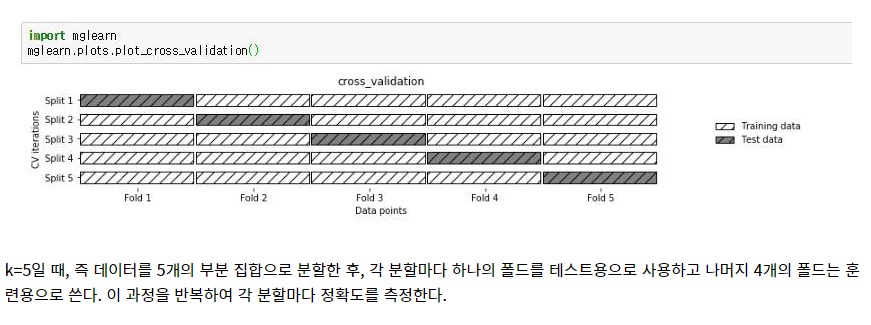

In [ ]:
import os
#os.chdir('/content/drive/MyDrive/dacon_cup/2차_open_data/open_data')
#데이터를 따로 업로드하기 때문에 directory 변경 미실시

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore') #윈도우 경고창을 무시하게 해줌

#시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go 

#MinMaxScaler모델
#모든 feature 값이 0~1사이에 있도록 데이터를 재조정한다. 
#다만 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축될 수 있다.

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsRegressor #최근접 이웃 회귀(*주석참고)
from sklearn.linear_model import LinearRegression #선형회귀
from sklearn.svm import SVR #Support Vector Regression (주석참고)
from sklearn.ensemble import RandomForestRegressor #랜덤포레스트 방식
#!pip install lightgbm
from lightgbm import LGBMRegressor #XGboost의 속도개량 버전

# import zipfile 
# with zipfile.ZipFile("open_data.zip") as zf:
#   zf.extractall()

SVR 

“회귀계수 크기를 작게하여 회귀식을 평평하게 만들되, 실제값과 추정값의 차이를 작도록 고려하는 선을 찾자” 라고 할 수 있습니다. 릿지 회귀 모형과 고려사항은 비슷하지만 더 중요하게 생각하는 목적이 다른 셈이죠.

실제값과 추정값의 차이를 적게해서 평탄화!

K-최근접 이웃(K-Nearest Neighbors) 회귀의 원리

K-Nearest Neighbors 알고리즘을 활용한 회귀도 결국엔 분류와 원리가 똑같다.

등급을 모르는 새로운 영화 데이터가 들어오면 거리 공식(Distance Formula)을 통해 가장 가까운 k개의 이웃을 찾을 거다. 분류에서는 이웃의 레이블 개수를 확인해서 다수결로 정했지만, 회귀에서는 이웃들의 평균을 계산한다는 점에서 차이가 있다. 그래서 만약 가장 새 영화와 가장 거리가 가까운(특성이 유사한) 3명의 이웃이 5.0, 6.8, 9.2의 등급을 가졌다면 이 영화의 등급이 7.0이라고 예상하는 거다.

In [ ]:
#모든 주어진 데이터를 각 변수에 담기(인코딩이 cp949 기입 필수)
train1 = pd.read_csv('1차_open_data/train.csv', encoding='cp949')
train2 = pd.read_csv('2차_open_data/2차_train.csv', encoding='cp949')
train = pd.concat([train1,train2],axis=0) #train 1과 2 합치기
submission = pd.read_csv('1차_open_data/submission.csv', encoding='cp949')

info_comp = pd.read_csv('new_competition_info.csv', encoding='cp949')
info_login = pd.read_csv('new_login_info.csv', encoding='cp949')
info_user = pd.read_csv('new_user_info.csv', encoding='cp949')
info_sub = pd.read_csv('new_submission_info.csv', encoding='cp949')

train.head() #train의 head요약정보 출력

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2018-09-09 00:00:00,19,19,8,206
1,2018-09-09 01:00:00,20,19,9,259
2,2018-09-09 02:00:00,12,9,1,48
3,2018-09-09 03:00:00,10,10,2,102
4,2018-09-09 04:00:00,6,5,3,18


In [ ]:
# train 데이터 일별로 summary

train['DateTime'] = pd.to_datetime(train['DateTime']) #주어진 데이터의 타입이 object인데, 이걸 날짜 정보로 바꾸어줘야함!
train['date'] = train['DateTime'].dt.date #날짜와 시간을 분리함 date에는 날짜만
train  = train.groupby('date').sum().reset_index() #train을 날짜순으로 정렬하고 각 속성의 합을 저장함
train.tail() #train의 마지막 값 출력

,date,사용자,세션,신규방문자,페이지뷰
817,2020-12-04,3189,3068,743,75730
818,2020-12-05,2055,2019,497,47638
819,2020-12-06,2119,2077,460,46914
820,2020-12-07,2979,2988,753,77443
821,2020-12-08,3033,2990,772,68857


In [ ]:
fig = go.Figure() #plotly.graph_objs 라이브러리의 추세를 나타내는 함수

fig.add_trace(go.Scatter(x=train['date'], y=train['사용자'])) #날짜별로 사용자수를 출력하라

Feature Extraction(특징 추출)

In [ ]:
# 모든 값이 결측치인 행은 제거
# 원본데이터를 보면 모든 속성이 0인 데이터가 있음, 불필요하므로 제거
#how='all' 옵션은 행의 모든 값이 결측치면 제거한다
comp = info_comp.dropna(how='all')
login = info_login.dropna(how='all')
user = info_user.dropna(how='all')
sub = info_sub.dropna(how='all')

In [ ]:
# comp 데이터 일별로 summary
#object 타입을 date 타입으로
comp['period_start'] = pd.to_datetime(comp['period_start']) 
comp['period_end'] = pd.to_datetime(comp['period_end'])

comp['start_date'] = comp['period_start'].dt.date
comp['end_date'] = comp['period_end'].dt.date

#시작 날짜순으로 정렬하고 대회 개수를 카운트, start date, cpt_id로 리셋
start_comp_fe = comp.groupby('start_date').count().reset_index()[['start_date','cpt_id']]
start_comp_fe.columns = ['date','start_comp_count'] #속성명 바꾸기

#종료 날짜순으로 정렬하고 카운트, 인덱스는 start date, cpt_id로 리셋
end_comp_fe = comp.groupby('end_date').count().reset_index()[['end_date','cpt_id']]
end_comp_fe.columns = ['date','end_comp_count']

start_comp_fe.head() # 날짜별 대회 시작 수

,date,start_comp_count
0,2018-08-14,1
1,2018-09-15,1
2,2018-10-18,1
3,2018-11-13,1
4,2018-12-25,1


In [ ]:
end_comp_fe.head() # 날짜별 대회 마감 수

,date,end_comp_count
0,2018-09-13,1
1,2018-10-13,1
2,2018-12-31,1
3,2019-01-10,1
4,2019-01-31,1


In [ ]:
# login 데이터 일별로 summary

login['c_time'] = pd.to_datetime(login['c_time'])
login['date'] = login['c_time'].dt.date

#nunique(): 유니크한 속성을 몇개 가지고 있는지
#unique(): 유니크한  속성을 무엇 무엇 가지고 있는지
#Unnamed 속성은 필요없으므로 제거하고, c_time속성은 date속성으로 대체되어 제거함
login_fe = login.groupby('date').nunique().reset_index().drop(['Unnamed: 0','c_time'],axis=1)

#속성명 설정 : groupby로 인해 날짜별로 누적된 수로 바뀌었으므로 속성명도 바꾸어줌
login_fe.columns = ['date','login_count','login_user','login_platform','login_browser']
login_fe.head()  # 날짜별 총 로그인 수, 접속한 유저 수, 사용한 플랫폼 수, 사용한 브라우저 수

,date,login_count,login_user,login_platform,login_browser
0,2018-09-23,35,18,6,11
1,2018-09-24,30,21,5,12
2,2018-09-25,18,14,2,6
3,2018-09-26,48,29,5,10
4,2018-09-27,31,23,3,9


In [ ]:
# user 데이터 일별로 summary
# 위의 작업과 마찬가지로 데이터 전처리
user['c_time'] = pd.to_datetime(user['c_time'])
user['date'] = user['c_time'].dt.date
user_fe = user.groupby('date').count()['id'].reset_index()
user_fe.columns = ['date','user_count']
user_fe.head() # 날짜별 가입 유저 수

,date,user_count
0,2017-05-02,1
1,2018-08-08,6
2,2018-08-09,1
3,2018-08-10,2
4,2018-08-12,1


In [ ]:
# submission 데이터 일별로 summary
# 위의 작업과 마찬가지로 데이터 전처리
sub['c_time'] = pd.to_datetime(sub['c_time'])
sub['date'] = sub['c_time'].dt.date
sub_fe = sub.groupby('date').nunique().reset_index().drop(['Unnamed: 0','c_time'],axis=1)
sub_fe.columns = ['date','sub_count','sub_cpt','sub_team','sub_user']
sub_fe.head() # 날짜별 총 제출 횟수, 제출이 발생한 대회 수, 제출한 팀 수, 제출한 유저 수

,date,sub_count,sub_cpt,sub_team,sub_user
0,2018-08-14,2,1,2,2
1,2018-08-15,1,1,1,1
2,2018-08-16,1,1,1,1
3,2018-08-17,1,1,1,1
4,2018-08-18,2,1,2,2


In [ ]:
# date 기준으로 feauture 전부 결합하여 최종 train 데이터셋 구축
#date를 기준으로 원래것의 왼쪽을 기준으로 데이터를 합쳐라
train_X = pd.merge(train,start_comp_fe,on='date',how='left')
train_X = pd.merge(train_X,end_comp_fe,on='date',how='left')
train_X = pd.merge(train_X,login_fe,on='date',how='left')
train_X = pd.merge(train_X,user_fe,on='date',how='left')
train_X = pd.merge(train_X,sub_fe,on='date',how='left')

#날짜데이터는 주말여부도 영향을 미치므로 속성을 추가한다
# 요일 및 주말여부 feature 생성
train_X['weekday'] = pd.to_datetime(train_X['date']).dt.weekday  # 요일타입의 속성을 추가
#한줄쓰기 기법(중요!)
train_X['holiday'] = [1 if (x == 5) | (x==6) else 0 for x in train_X['weekday']]  # 주말 여부 구분
# 같은문장 : weekday의 값이 5, 6이면 hoilday에 1을 넣고 아니면 0을 넣어라
# for x in train_X['weekday'] :
#   if(x==5 or x==6) :
#     train_X['holiday'] = 1
#   else :
#     train_X['holiday'] = 0

train_X = train_X.fillna(0)

train_X

,date,사용자,세션,신규방문자,페이지뷰,start_comp_count,end_comp_count,login_count,login_user,login_platform,login_browser,user_count,sub_count,sub_cpt,sub_team,sub_user,weekday,holiday
0,2018-09-09,281,266,73,1826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1
1,2018-09-10,264,247,51,2092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,2018-09-11,329,310,58,1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,2018-09-12,300,287,45,2595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
4,2018-09-13,378,344,50,3845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,2020-12-04,3189,3068,743,75730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0
818,2020-12-05,2055,2019,497,47638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1
819,2020-12-06,2119,2077,460,46914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1
820,2020-12-07,2979,2988,753,77443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [ ]:
# test 데이터셋도 동일하게 생성
#DataFrame 열을 string으로 변환하기
#이유 : 원래 주어진 csv의 data값이 string이었기 때문 / 나중에 평가하려면 타입이 같아야함
submission['DateTime'] = submission['DateTime'].astype(str)
start_comp_fe['date'] = start_comp_fe['date'].astype(str)
end_comp_fe['date'] = end_comp_fe['date'].astype(str)
login_fe['date'] = login_fe['date'].astype(str)
user_fe['date'] = user_fe['date'].astype(str)
sub_fe['date'] = sub_fe['date'].astype(str)

#submission에서 datetime만 따로 빼냄
temp_sub = submission[['DateTime']]
#속성명 이름바꾸기
temp_sub.columns = ['date']

test_X = pd.merge(temp_sub,start_comp_fe,on='date',how='left')
test_X = pd.merge(test_X,end_comp_fe,on='date',how='left')
test_X = pd.merge(test_X,login_fe,on='date',how='left')
test_X = pd.merge(test_X,user_fe,on='date',how='left')
test_X = pd.merge(test_X,sub_fe,on='date',how='left')

# 요일 및 주말여부 feature 생성(방법 전과동)
test_X['weekday'] = pd.to_datetime(test_X['date']).dt.weekday
test_X['holiday'] = [1 if (x == 5) | (x==6) else 0 for x in test_X['weekday']]

test_X = test_X.fillna(0) #결측치(NaN)를 0으로 바꿔주기

test_X

,date,start_comp_count,end_comp_count,login_count,login_user,login_platform,login_browser,user_count,sub_count,sub_cpt,sub_team,sub_user,weekday,holiday
0,2020-11-09,0.0,0.0,460.0,397.0,0.0,0.0,162,511,20,224,212,0,0
1,2020-11-10,0.0,0.0,356.0,315.0,0.0,0.0,75,504,13,218,213,1,0
2,2020-11-11,2.0,0.0,504.0,398.0,0.0,0.0,86,587,15,247,237,2,0
3,2020-11-12,0.0,0.0,394.0,332.0,0.0,0.0,61,571,17,251,245,3,0
4,2020-11-13,0.0,2.0,397.0,332.0,0.0,0.0,74,609,18,263,265,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2021-01-04,0.0,0.0,0.0,0.0,0.0,0.0,117,283,10,121,129,0,0
57,2021-01-05,0.0,0.0,0.0,0.0,0.0,0.0,101,268,14,121,131,1,0
58,2021-01-06,1.0,0.0,0.0,0.0,0.0,0.0,100,430,18,180,197,2,0
59,2021-01-07,0.0,0.0,0.0,0.0,0.0,0.0,81,412,15,176,197,3,0


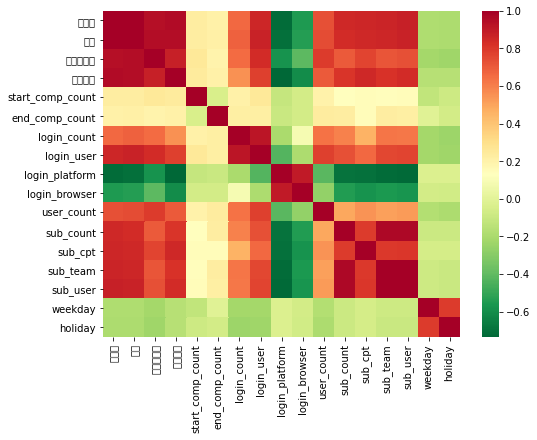

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(train_X.corr(), cmap='RdYlGn_r')
#상관관계를 시각화해서 어떤 속성끼리 연관이 있는지 한눈에 보기
# 사용자,세션,신규방문자,페이지뷰는 서로 비슷한 양상을 보임
# 날짜별 총 로그인 수, 접속한 유저 수, 가입 유저 수, 총 제출 수, 제출이 발생한 대회 수, 제출한 팀 수, 제출한 유저 수가 종속변수들과 높은 상관관계를 보임

Model

In [ ]:
# 독립변수와 종속변수 분할
#iloc: 속성자르기
y_user = train_X.iloc[:,1] #1번째에 있는 열을 전체 가져와라
y_session = train_X.iloc[:,2]
y_visit = train_X.iloc[:,3]
y_view = train_X.iloc[:,4]
X_train = train_X.iloc[:,5:] #처음 5개 속성은 몰라야하니까 제외 / y_train에있음
print(X_train)
X_test = test_X.iloc[:,1:] #마찬가지로 date는 몰라야하니까 제외 / y_test를 통해 알아낼거임
print(X_test)

     start_comp_count  end_comp_count  login_count  ...  sub_user  weekday  holiday
0                 0.0             0.0          0.0  ...      18.0        6        1
1                 0.0             0.0          0.0  ...      21.0        0        0
2                 0.0             0.0          0.0  ...      22.0        1        0
3                 0.0             0.0          0.0  ...      21.0        2        0
4                 0.0             1.0          0.0  ...      26.0        3        0
..                ...             ...          ...  ...       ...      ...      ...
817               0.0             1.0        276.0  ...     136.0        4        0
818               0.0             0.0        143.0  ...      70.0        5        1
819               0.0             0.0         95.0  ...      72.0        6        1
820               0.0             0.0          0.0  ...     113.0        0        0
821               0.0             0.0          0.0  ...      98.0        1  

In [ ]:
# 최소-최대 정규화 수행
#모든 값을 1과 0사이의 값으로 축소
#fit : 학습데이터를 채운다
#fit_transform : fit + transform
#스케일링 적용하기 위해서 X_train에서 Max와 min을 찾아서 Max-min값으로 나눔
#X_test는 X_train과 동일한 Max-min으로 나눠줘야하기 때문에 fit(찾기) 미실시
ms = MinMaxScaler()
X_train_m = pd.DataFrame(ms.fit_transform(X_train))
X_test_m = pd.DataFrame(ms.transform(X_test))

In [ ]:
# 개별 모델 성능 (RMSE) 확인

knn_model = KNeighborsRegressor()
svr_model = SVR()
lr_model = LinearRegression()
rf_model = RandomForestRegressor()
lgb_model = LGBMRegressor()

In [ ]:
#cross_var_score(모델명, 훈련데이터, 타깃, 몇곂으로 교차검증할 지)
#train 값을 다시한번 train과 test로 나누어 5번 예측하고 평균을 냄
#각 모델(알고리즘) 별로 성적을 저장함
cross_score_knn = cross_val_score(knn_model, X_train_m, y_user, scoring='neg_mean_squared_error', cv=5)
cross_score_lr = cross_val_score(lr_model, X_train_m, y_user, scoring='neg_mean_squared_error', cv=5)
cross_score_svr = cross_val_score(svr_model, X_train_m, y_user, scoring='neg_mean_squared_error', cv=5)
cross_score_rf = cross_val_score(rf_model, X_train_m, y_user, scoring='neg_mean_squared_error', cv=5)
cross_score_lgb = cross_val_score(lgb_model, X_train_m, y_user, scoring='neg_mean_squared_error', cv=5)

#이미 score가 (A-B)^2 로 점수가 부풀려져있어서 루트를 씌워서 A-B(단순오차)를 구해야함
r_score_knn = np.sqrt(-cross_score_knn)
r_score_lr = np.sqrt(-cross_score_lr)
r_score_svr = np.sqrt(-cross_score_svr)
r_score_rf = np.sqrt(-cross_score_rf)
r_score_lgb = np.sqrt(-cross_score_lgb)

In [ ]:
#각모델별 5번의 오차(낮을수록 좋음), 오차의 평균(mean)을 출력
print("KNN score :",r_score_knn, " / KNN mean score", r_score_knn.mean())
print("LR score :",r_score_lr, " / LR mean score", r_score_lr.mean())
print("SVR score :",r_score_svr, " / SVR mean score", r_score_svr.mean())
print("RF score :",r_score_rf, " / RF mean score", r_score_rf.mean())
print("LGB score :",r_score_lgb, " / LGB mean score", r_score_lgb.mean())
#lr score : 즉 선형 회귀의 평균값이 289정도로 가장 낮다는걸 알 수 있다. 이 모델을 채택!

KNN score : [319.5788471  186.80204009 451.77081579 493.64866123 915.08243291]  / KNN mean score 473.37655942447566
LR score : [217.66515827 241.52447142 326.86298254 248.83809695 410.21498471]  / LR mean score 289.0211387787036
SVR score : [ 980.53184293  838.46842098  467.72502002 1300.47155832 2316.18608441]  / SVR mean score 1180.6765853331103
RF score : [396.54706188 174.42099072 548.08670808 342.80104318 673.84847367]  / RF mean score 427.1408555048236
LGB score : [255.38269372 173.51187883 438.1248591  394.9494829  695.29065258]  / LGB mean score 391.45191342629795


Prediction

In [ ]:
# 선형회귀로 학습시킨후 y_test를 예측하는 일만 남음

# 선형회귀 모델 적합 및 예측 - 사용자
lr_model = LinearRegression()
lr_model.fit(X_train_m,y_user) # 학습시킴
submission['사용자'] = lr_model.predict(X_test_m)
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4947.876864,0,0,0
1,2020-11-10,3866.086599,0,0,0
2,2020-11-11,4523.979900,0,0,0
3,2020-11-12,4204.489886,0,0,0
4,2020-11-13,4468.302351,0,0,0


In [ ]:
# 선형회귀 모델 적합 및 예측 - 세션

lr_model = LinearRegression()
lr_model.fit(X_train_m,y_session)
submission['세션'] = lr_model.predict(X_test_m)
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4947.876864,4931.680871,0,0
1,2020-11-10,3866.086599,3785.458137,0,0
2,2020-11-11,4523.979900,4448.228889,0,0
3,2020-11-12,4204.489886,4092.749622,0,0
4,2020-11-13,4468.302351,4324.905845,0,0


In [ ]:
# 선형회귀 모델 적합 및 예측 - 신규방문자

lr_model = LinearRegression()
lr_model.fit(X_train_m,y_visit)
submission['신규방문자'] = lr_model.predict(X_test_m)
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4947.876864,4931.680871,1298.166959,0
1,2020-11-10,3866.086599,3785.458137,878.332240,0
2,2020-11-11,4523.979900,4448.228889,1069.111621,0
3,2020-11-12,4204.489886,4092.749622,909.626673,0
4,2020-11-13,4468.302351,4324.905845,958.724827,0


In [ ]:
# 선형회귀 모델 적합 및 예측 - 페이지뷰

lr_model = LinearRegression()
lr_model.fit(X_train_m,y_view)
submission['페이지뷰'] = lr_model.predict(X_test_m)
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4947.876864,4931.680871,1298.166959,124792.636042
1,2020-11-10,3866.086599,3785.458137,878.332240,95312.060163
2,2020-11-11,4523.979900,4448.228889,1069.111621,113438.234983
3,2020-11-12,4204.489886,4092.749622,909.626673,102299.593751
4,2020-11-13,4468.302351,4324.905845,958.724827,120666.041125


Submission(제출 양식에 맞게 저장)

In [ ]:
submission.to_csv('submission.csv',index=False,encoding='cp949')